In [17]:

get_price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

set_price_function = {
    "name": "set_ticket_price",
    "description": "Set the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
            "price": {"type": "integer", "description": "The price of the ticket"},
        },
        "required": ["destination_city", "price"],
        "additionalProperties": False
    }
}


In [18]:
tools = [{"type": "function", "function": get_price_function},{
    "type": "function",
    "function": set_price_function
}]

In [19]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [20]:
load_dotenv()
MODEL = "gpt-4.1-mini"
client = OpenAI()

In [21]:
system_message ="""
You are chatBot for IRCTC . Keep your answers concise and to the point.
Your answers shoud be small one-liners.If you dont know the answer, just say "I don't know. if Asked to update the price, Check whether it already exists with help of tools,if already exists, dont update it"
"""

In [22]:
import sqlite3

In [23]:
DB = "prices.db"

with sqlite3.connect(DB) as conn:
    cursor = conn.cursor()
    cursor.execute('CREATE TABLE IF NOT EXISTS prices (city TEXT PRIMARY KEY, price REAL)')
    conn.commit()

In [24]:
def get_ticket_price(city):
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city=?', (city,))
        result = cursor.fetchone()
        return f"The price of the ticket to {city} is {result[0]}" if result else "Price not found for this city"
        
def set_ticket_price(city, price):
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('INSERT INTO prices (city, price) VALUES (?, ?)', (city, price))
        conn.commit()
        return f"The price of the ticket to {city} has been set to {price}"

In [25]:
def handle_tool_calls(message):
    responses = []
    cities =[]
    for tool_call in message.tool_calls:
        if tool_call.function.name == "get_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price_details = get_ticket_price(city)
            responses.append({
                "role": "tool",
                "content": price_details,
                "tool_call_id": tool_call.id
            })
        elif tool_call.function.name == "set_ticket_price":
            arguments = json.loads(tool_call.function.arguments)
            city = arguments.get('destination_city')
            cities.append(city)
            price = arguments.get('price')
            set_ticket_price(city, price)
            responses.append({
                "role": "tool",
                "content": f"The price of the ticket to {city} has been set to {price}",
                "tool_call_id": tool_call.id
            })
    return responses , cities

In [26]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history
    response = client.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses, cities = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = client.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = artist(cities[0])
    
    return history, image, voice


In [27]:
gr.ChatInterface(chat, type="messages").launch()

/Users/siddarthalegala/projects/LLMEngineeringLearning/.venv/lib/python3.12/site-packages/gradio/utils.py:1052: UserWarning: Expected 1 arguments for function <function chat at 0x10e718400>, received 2.
  warnings.warn(
/Users/siddarthalegala/projects/LLMEngineeringLearning/.venv/lib/python3.12/site-packages/gradio/utils.py:1060: UserWarning: Expected maximum 1 arguments for function <function chat at 0x10e718400>, received 2.
  warnings.warn(
/Users/siddarthalegala/projects/LLMEngineeringLearning/.venv/lib/python3.12/site-packages/gradio/utils.py:1052: UserWarning: Expected 1 arguments for function <function chat at 0x110f9d760>, received 2.
  warnings.warn(
/Users/siddarthalegala/projects/LLMEngineeringLearning/.venv/lib/python3.12/site-packages/gradio/utils.py:1060: UserWarning: Expected maximum 1 arguments for function <function chat at 0x110f9d760>, received 2.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


In [28]:

import base64
from io import BytesIO
from PIL import Image

In [29]:
def artist(city):
    image_response = client.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

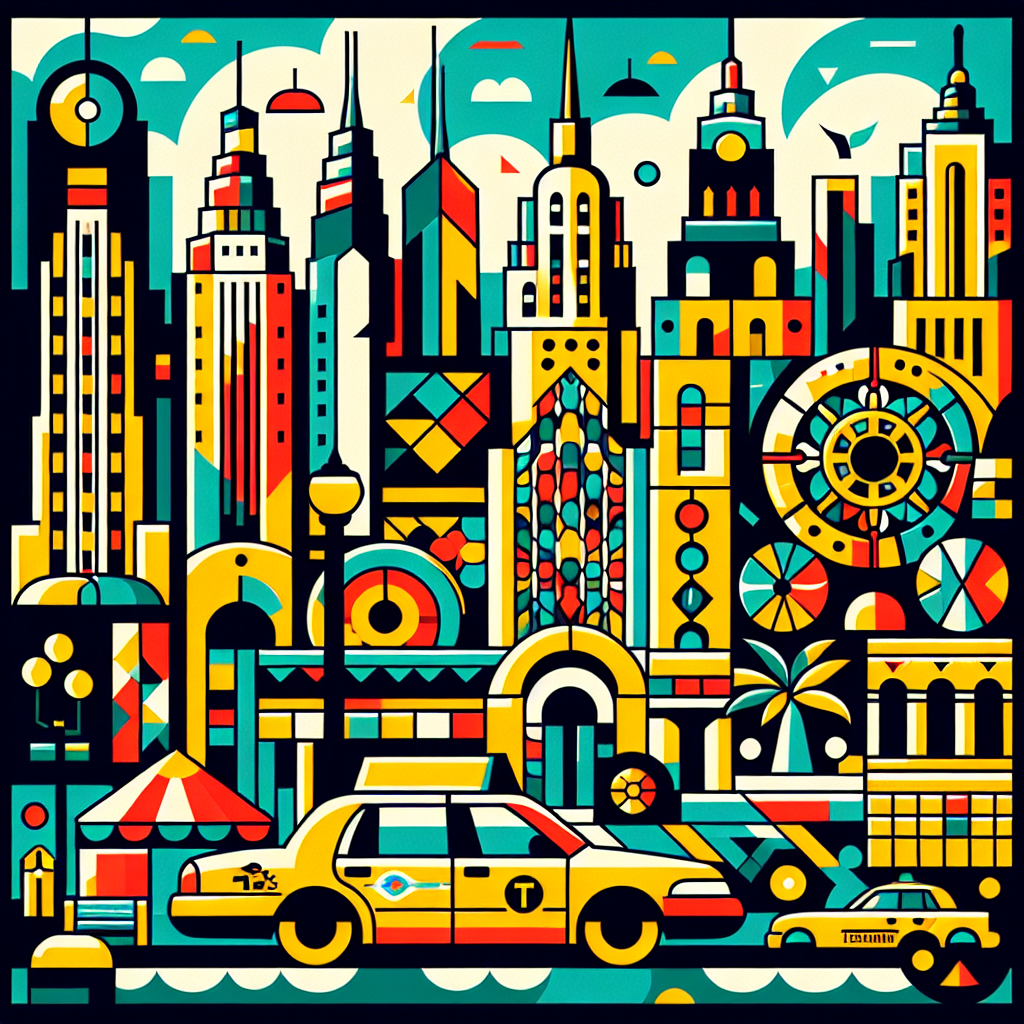

In [30]:
image = artist("New York City")
display(image)

In [31]:
def talker(message):
    response = client.audio.speech.create(
      model="gpt-4o-mini-tts",
      voice="onyx",    # Also, try replacing onyx with alloy or coral
      input=message
    )
    return response.content

In [32]:
# Callbacks (along with the chat() function above)

def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

# UI definition

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

# Hooking up events to callbacks

    message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output,audio_output]
    )

ui.launch(inbrowser=False)

/var/folders/t0/v7t1g6px5_qdwtfr81fbsrf40000gn/T/ipykernel_4455/3957157232.py:10: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(height=500, type="messages")


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
